# KUKA - Document Rectification
This jupyter notebook focus on Perspective rectification and background croping for document type A4,A5
These document may be has background or not ; present full document edges or not



### Reference
- https://dropbox.tech/machine-learning/fast-and-accurate-document-detection-for-scanning
- https://www.microsoft.com/en-us/research/uploads/prod/2016/12/Whiteboard-It.pdf
- https://stackoverflow.com/questions/7263621/how-to-find-corners-on-a-image-using-opencv
- https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv

#### History
- 23-05-2023
    - select quadrangle with criterion base on paper: Complex document classifiaction adn localization application on Identity document images

In [1]:
import sys
import os
import glob
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(0, 'd:/Project/kuka-py/')
runingPath=os.path.abspath("")
parentPath = Path(runingPath).resolve().parents[0]
if(sys.path[0]!=parentPath):
    sys.path.insert(0, parentPath)

from kukalib.cardcrop  import  *
print(getVersionInfo())

{'version': '0.3.2', 'date': datetime.date(2023, 6, 19)}


## Load image

gray shape: (960, 1280)


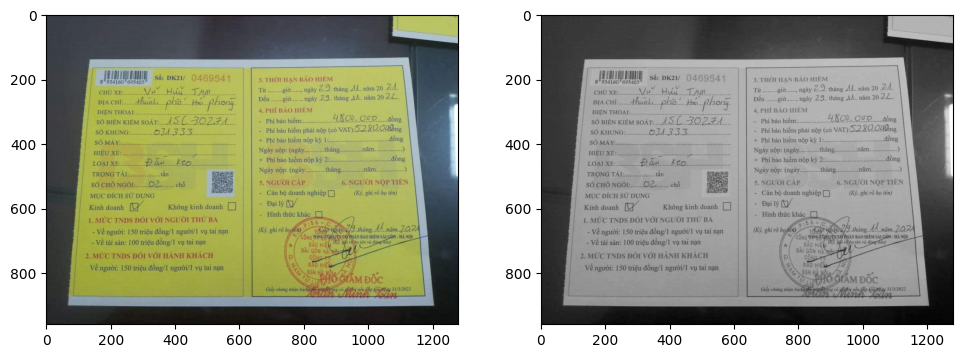

In [145]:


#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_23.jpg"
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_27.jpg"
filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_2.jpg"


src=cv2.imread(filename)

gray=cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

print('gray shape:',gray.shape)
figSizeA4=(11.7,8.3)
plt.figure(figsize=figSizeA4)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(gray,cmap='gray')
plt.show()

## Step 1: try to extract background
### using Morph_Close to remove text

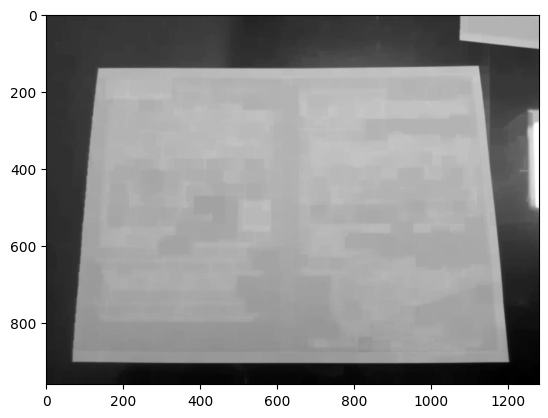

In [146]:
kernel=np.ones((7,7),np.uint8)
dilectImg=cv2.morphologyEx(src,cv2.MORPH_CLOSE,kernel,iterations=5)

gray=cv2.cvtColor(dilectImg,cv2.COLOR_BGR2GRAY)
    
blurImg=cv2.GaussianBlur(gray,(5,5),0)

plt.imshow(blurImg,cmap='gray')
plt.show()

## Step 2: edge and line detect

In [147]:
sobelImg=sobel(blurImg)
#sobelImg=cv2.Canny(blurImg,0,250,apertureSize=3)
ret1,edgeImg = cv2.threshold(sobelImg,40,200, cv2.THRESH_OTSU + cv2.THRESH_TOZERO + cv2.THRESH_BINARY)

## make egde more dilect
edgeImg=cv2.morphologyEx(edgeImg,cv2.MORPH_DILATE,(2,2),iterations=2)

linesP = cv2.HoughLinesP(edgeImg,rho=1,theta=1*np.pi/180,threshold=50,minLineLength=30,maxLineGap=10)


Num of line hough probility: 58 - shape:  (58, 1, 4)


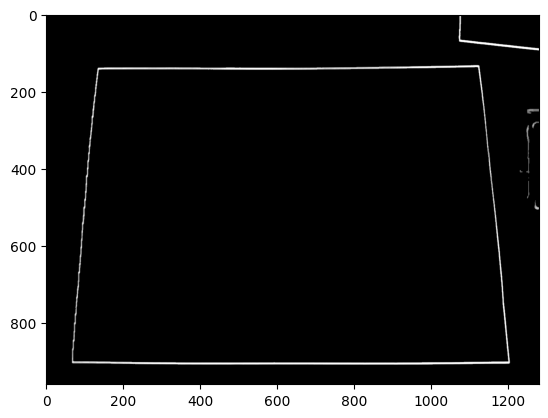

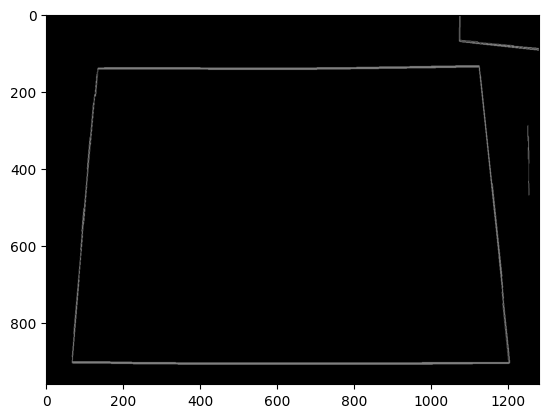

In [148]:
# print debug line
lineImg=np.zeros(src.shape,dtype=np.int8)
print('Num of line hough probility:', len(linesP), "- shape: " , linesP.shape )
for line in linesP:
    x1=line[0][0]
    y1=line[0][1]
    x2=line[0][2]
    y2=line[0][3]
    cv2.line(lineImg,(x1,y1),(x2,y2),(255,255,255),1)

plt.imshow(edgeImg,cmap='gray')
plt.show()
#plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
plt.imshow(lineImg)
plt.show()

## Step 3: trying to find quadrilateral by estimating 4 lines: top/bottom , left/right
    Asumption:
        - card is nearly center of image
        - 4 edges of card nearly present in the image
    

### expreriment line fiting

In [149]:
# def getLinebyParams(fit_line,shape):
#     """
#     input fit_line [vx,vy,x0,y0]
#     return [(x1,y1),(x2,y2)]
#     """
#     # compute t0 for y=0 and t1 for y=img.shape[0]: (y-y0)/vy
#     t0 = (0-fit_line[3])/fit_line[1]
#     t1 = (shape[0]-fit_line[3])/fit_line[1]

#     # plug into the line formula to find the two endpoints, p0 and p1
#     # to plot, we need pixel locations so convert to int
#     p0 = (fit_line[2:4] + (t0 * fit_line[0:2])).astype(np.uint32)
#     p1 = (fit_line[2:4] + (t1 * fit_line[0:2])).astype(np.uint32)
#     return (np.squeeze(p0),np.squeeze(p1))

def getLinebyParams2(fit_line,shape):
    m=max(shape[0],shape[1])
    m = int(m/2)
    p0= (int(fit_line[2]-m*fit_line[0]), int(fit_line[3]-m*fit_line[1]))
    p1= (int(fit_line[2]+m*fit_line[0]), int( fit_line[3]+m*fit_line[1]))
    return [p0,p1]

def getFitLine(lineList,imgShape):
    num_line=len(lineList)
    listPoints=lineList.reshape(num_line*2,2).astype(dtype=np.int32)
    fit_line = cv2.fitLine(listPoints,cv2.DIST_L2,0,0.01,0.01)
    fitline = getLinebyParams2(fit_line,imgShape)
    return fitline

### experiment: trying geting line with hough

In [150]:
def drawLine(src,srcWidth,srcHeight,lines,lineColor,lineWidth):

  diagonal_len = int(math.sqrt(math.pow(srcWidth,2)+math.pow(srcHeight,2)))*2

  for r_theta in lines:
    arr = np.array(r_theta[0], dtype=np.float64)
    r, theta = arr
    # Stores the value of cos(theta) in a
    a = np.cos(theta)
  
    # Stores the value of sin(theta) in b
    b = np.sin(theta)
  
    # x0 stores the value rcos(theta)
    x0 = a*r
  
    # y0 stores the value rsin(theta)
    y0 = b*r
  
    # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
    x1 = int(x0 + diagonal_len*(-b))
  
    # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
    y1 = int(y0 + diagonal_len*(a))
  
    # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
    x2 = int(x0 - diagonal_len*(-b))
  
    # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
    y2 = int(y0 - diagonal_len*(a))
    
    # cv2.line draws a line in img from the point(x1,y1) to (x2,y2).
    # (0,0,255) denotes the colour of the line to be
    # drawn. In this case, it is red.
    cv2.line(src, (x1, y1), (x2, y2), lineColor, lineWidth)
  return src 



minline_threshold: 192
num line hough: 33


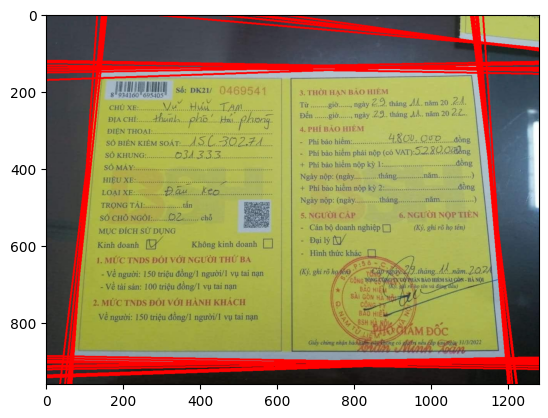

In [151]:
minline_threshold  = int(min(gray.shape[0],gray.shape[1]) /5)
print ('minline_threshold:',minline_threshold)
lines = cv2.HoughLines(edgeImg,1,1*np.pi/180,minline_threshold)
print('num line hough:',len(lines))

houghLineImg = src.copy()
houghLineImg=drawLine(houghLineImg,houghLineImg.shape[1],houghLineImg.shape[2],lines, (0,0,255),3)

plt.imshow(cv2.cvtColor(houghLineImg,cv2.COLOR_BGR2RGB))
plt.show()

(33, 2)
2656.2391850948334


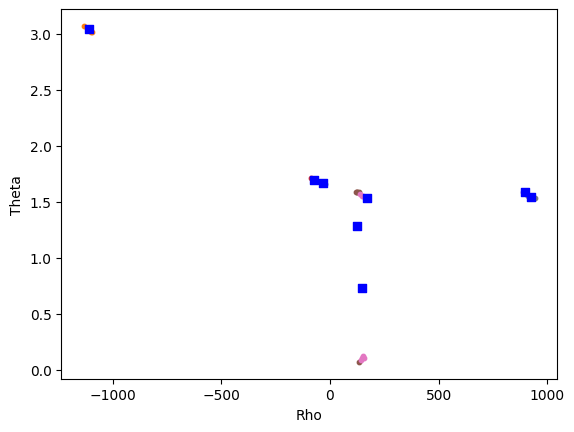

In [152]:


Z = np.squeeze(lines)
print(Z.shape)
# define criteria and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
kcenter=8
if(kcenter>len(lines)):
    kcenter=len(lines)
ret,label,center=cv2.kmeans(Z,kcenter,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now separate the data, Note the flatten()
A = Z[label.ravel()==0]
B = Z[label.ravel()==1]
C = Z[label.ravel()==2]
D = Z[label.ravel()==3]
print(ret)
# Plot the data
for i in range(kcenter):
    plt.scatter(Z[label.ravel()==i][:,0],Z[label.ravel()==i][:,1],s=10)
plt.scatter(center[:,0],center[:,1],s = 30,c = 'b', marker = 's')
plt.xlabel('Rho'),plt.ylabel('Theta')
plt.show()

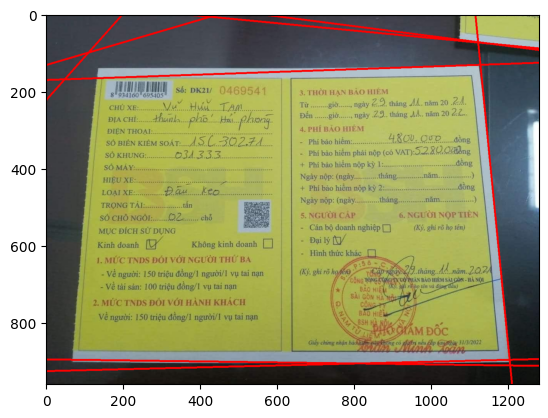

In [153]:
c_lines = np.expand_dims(center,axis=1)

houghLineImg = src.copy()
houghLineImg=drawLine(houghLineImg,houghLineImg.shape[1],houghLineImg.shape[2],c_lines, (0,0,255),3)

plt.imshow(cv2.cvtColor(houghLineImg,cv2.COLOR_BGR2RGB))
plt.show()

Merge line
- https://stackoverflow.com/questions/30746327/get-a-single-line-representation-for-multiple-close-by-lines-clustered-together
- https://answers.opencv.org/question/68781/partition-finding-the-number-of-clusters/


In [154]:
def euclideanDistance(prop1,prop2):
    distance = math.sqrt(prop1*prop1+prop2*prop2)
    return distance

def groupingLine(lines,roh_threshold,theta_threshold):
    num_line = len(lines)
    combineIndex=[]
    for i in range(num_line):
        combineIndex.append([])
    combineLines=[]
    max_threshold = euclideanDistance(roh_threshold,theta_threshold)
    for i in range(num_line):
        index = i
        for j in range(i,num_line):
            distanceI = lines[i][0]
            distanceJ = lines[j][0]
            slopeI =lines[i][1]
            slopeJ =lines[j][1]
            disDiff = abs(distanceI - distanceJ)
            slopeDiff = abs(slopeI-slopeJ)
            linedistance =euclideanDistance(slopeDiff,disDiff)
            if(linedistance<=max_threshold):
                isCombined = False
                for w in range(i):
                    for u in range(len(combineIndex[w])):
                        if combineIndex[w][u] == j:
                            isCombined=True
                            break
                        if(combineIndex[w][u]==i): 
                            index =w
                    if(isCombined):
                        break
                if(not isCombined):
                   combineIndex[index].append(j)
    
    for i in range(len(combineIndex)):
        if(len(combineIndex[i])==0):
            continue
        linetemp=[0.,0.]
        for j in range(len(combineIndex[i])):
            linetemp[0] += lines[combineIndex[i][j]][0]
            linetemp[1] += lines[combineIndex[i][j]][1]
        linetemp[0] /=len(combineIndex[i])
        linetemp[1] /=len(combineIndex[i])
        combineLines.append(linetemp)
    
    return combineLines
           
    
    

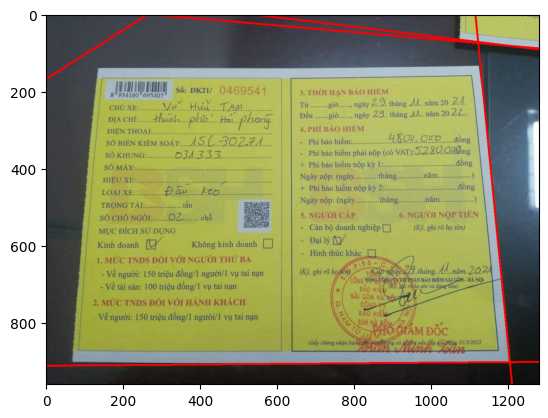

In [155]:
rho_threshold =20
theta_thresold = 3*np.pi/180
combinelines = groupingLine(np.squeeze(lines),rho_threshold,theta_thresold)

c_lines = np.expand_dims(combinelines,axis=1)

houghLineImg = src.copy()
houghLineImg=drawLine(houghLineImg,houghLineImg.shape[1],houghLineImg.shape[2],c_lines, (0,0,255),3)

plt.imshow(cv2.cvtColor(houghLineImg,cv2.COLOR_BGR2RGB))
plt.show()

In [156]:

def clusterTBLRLineList(lines,img_heigh,img_width):
    '''
        input: lines in (rho,theta) array
        return top,bottom,left,right line list
    '''
    topLineList=[]
    bottomLineList=[]
    leftLineList=[]
    rightLineList=[]

    heigh = img_heigh
    width = img_width
    diagonal = math.sqrt(heigh*heigh+width*width)
    for i in range(len(lines)):
        rho,theta=lines[i]
        theta =theta*180/np.pi
        rho=abs(rho)
        print(theta,rho)
        if(theta<=90 and theta>=50): #top/bottom
            if(rho<=heigh/2):
                topLineList.append(lines[i])
            else:
                bottomLineList.append(lines[i])
        else:
            if(rho<=width/2):
                leftLineList.append(lines[i])
            else:
                rightLineList.append(lines[i])

    topLineList=np.asarray(topLineList)
    bottomLineList=np.asarray(bottomLineList)
    leftLineList=np.asarray(leftLineList)
    rightLineList=np.asarray(rightLineList)
    return topLineList,bottomLineList,leftLineList,rightLineList



90.00000250447816 904.0
90.00000250447816 139.0
4.99999985454646 144.0
89.00000133828577 152.0
173.99999801180195 1104.0
90.99999684048139 899.0
89.00000133828577 922.0
174.99999234780518 1117.0
90.99999684048139 133.0
3.999999969014533 132.0
6.000000166965211 149.0
90.99999684048139 893.0
89.00000133828577 916.0
89.00000133828577 146.0
88.00000017209338 171.0
89.00000133828577 913.0
173.00000367579872 1097.0
173.00000367579872 1095.0
88.00000017209338 942.0
176.00000034418676 1132.0
7.000000052497138 153.0
174.99999234780518 1112.0
90.99999684048139 887.0
90.99999684048139 125.0
96.99999700744661 63.0
95.00000150525098 23.0
96.00000267144338 45.0
96.99999700744661 65.0
88.00000017209338 937.0
6.000000166965211 156.0
90.99999684048139 123.0
97.999998173639 85.0
90.99999684048139 121.0


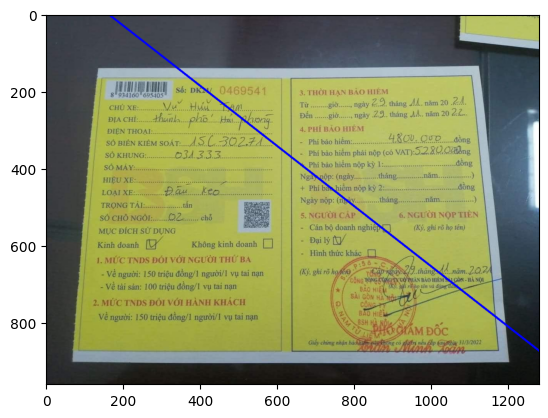

In [157]:
topLineList=[]
bottomLineList=[]
leftLineList=[]
rightLineList=[]

heigh=gray.shape[0]
width=gray.shape[1]

topLineList,bottomLineList,leftLineList,rightLineList = clusterTBLRLineList(np.squeeze(lines),heigh,width)
topLineList=np.expand_dims(topLineList,axis=1)
bottomLineList=np.expand_dims(bottomLineList,axis=1)
leftLineList=np.expand_dims(leftLineList,axis=1)
rightLineList=np.expand_dims(rightLineList,axis=1)

assert(len(lines)==(len(topLineList)+len(bottomLineList)+len(leftLineList)+len(rightLineList)))

debugImg = src.copy()
#debugImg=drawLine(debugImg,heigh,width,leftLineList, (0,0,255),3)

testLine = [[[-100,128*np.pi/180]]]
debugImg=drawLine(debugImg,heigh,width,testLine, (255,0,0),3)
plt.imshow(cv2.cvtColor(debugImg,cv2.COLOR_BGR2RGB))
plt.show()


## Dùng thuật toán đường biên dài nhất
1. Xác dịnh line => dùng houghp đề xác định các line với (x1,y1,x2,y2) => thresold = 1/5 * min(w,h)
2. Clustering lines into groups top / bottom / left/right
2. Fitting line / average line => for each group
    1. chuyển line (x1,y1,x2,y2) => về dạng slopes (b,m)
    2. grouping các line theo (b,m) + khoảng cách giữa các line => được danh sách tham chiếu [line_index] -> [line_in_group]
    3. duyệt theo danh sách tham chiếu => tạo các fitting line
    4. trả lại danh sách sau khi đã fitting
3. Tìm ra quadrangle 
    1. cluster => top/bottom/left/right
    2. soft t/b/l/r line theo length
    3. lấy ra 1 bộ (t,b,l,r) =>lựa chọn quadrangle thỏa mãn các điều kiện về góc va cạnh
- https://sbme-tutorials.github.io/2021/cv/notes/4_week4.html#getting-value-of-rho-and-theta
- https://dsp.stackexchange.com/questions/81992/how-to-convert-a-line-that-goes-through-the-origin-into-hough-space
- https://stackoverflow.com/questions/71811385/how-to-connect-disjointed-lines-or-edges-in-images

In [158]:
def clusteringLineInTBLR(lines,img_heigh,img_width):
    '''
        lines in shape (x1,y1,x2,y2)
        return list of top/bottom/left/right in separate
    '''
    toplineList=[]
    bottomlineList=[]
    leftlineList=[]
    rightlineList=[]

    xcenter=img_width/2
    ycenter=img_heigh/2
    # grouping lines in top,bottom,left,right

    for line in lines:
        p1=line[0][0:2]
        p2=line[0][2:4]
        angle= getLineAngle(p1,p2)
        linelength=getLineLength(p1,p2)
        angle=abs(angle)
        if(angle<40): # top/bottom line
            if(p1[1]+p2[1])/2 < ycenter:
                toplineList.append(line)
            elif (p1[1]+p2[1])/2 > ycenter:
                bottomlineList.append(line)
        else:
            if (p1[0]+p2[0])/2 < xcenter:
                leftlineList.append(line)
            elif (p1[0]+p2[0])/2 > xcenter:
                rightlineList.append(line)

    # converting list(object) to ndarray then sorting length by descending
    # if(len(toplineList) and len(bottomlineList) and len(leftlineList) and len(rightlineList)):
    #     toplineList = np.vstack(toplineList)
    #     bottomlineList = np.vstack(bottomlineList)
    #     leftlineList= np.vstack(leftlineList)
    #     rightlineList = np.vstack(rightlineList)
    
    toplineList = np.asarray(toplineList)
    bottomlineList = np.asarray(bottomlineList)
    leftlineList= np.asarray(leftlineList)
    rightlineList = np.asarray(rightlineList)

    return toplineList,bottomlineList,leftlineList,rightlineList

def sortLinePoint(lines,sort_axis):
    '''
        input lines in shape (num_line,4) each line is (x1,y1,x2,y2)
        sort_axis = 0 : sort by X otherwise sorting by Y
        perfome 2 sorting
            first sorting point P1,P1 in a line 
            second sorting line in lines  array
    '''
    #first sort
    assert(len(lines.shape)==2)
    for i in range(len(lines)):
        lineItem= lines[i].reshape(2,2)
        lineItem = lineItem[lineItem[:,sort_axis].argsort()]
        lines[i] = lineItem.reshape(1,4)
    #second sort
    lines = lines[lines[:,sort_axis].argsort()]

    return lines

def getLineLengthAngle(lines):
    '''
        add extra infomation length and angle to line in shape(num_line,4)
        return
            (x1,y1,x2,y2,length,angle)
    '''
    newList = []
    for line in lines:
        p1=line[0:2]
        p2=line[2:4]
        angle= getLineAngle(p1,p2)
        linelength=getLineLength(p1,p2)
        lineExtend=np.append(line[0:4],[round(linelength),round(angle)])
        newList.append(lineExtend)
    newList=np.asarray(newList)
    return newList

def drawLinePoint(img,linesP,lineColor,lineWidth):
  for line in linesP:
    x1=int(line[0])
    y1=int(line[1])
    x2=int(line[2])
    y2=int(line[3])
    cv2.line(img,(x1,y1),(x2,y2),lineColor,lineWidth) 

def convertLinePoint2Slope(linesP):
    '''
        convert line by 2 point (x1,y1,x2,y2) to format slope and y-intercept (mb) y=mx+b
        m = (x2-x1) / y2-y1 ; b = y1-mx1
    '''
    newList =[]
    for line in linesP:
        xDiff = line[2] - line[0]
        yDiff = line[3] - line[1]
        if(xDiff==0):
            m=0
            b=line[0]
        else:
            m = yDiff/xDiff
            b = line[1] - m*line[0]
        newline =[line[0],line[1],line[2],line[3],m,b]
        newList.append(newline)
    newList = np.asarray(newList)
    return newList

def convertLinePoint2RhoTheta(linesP):
    '''
        add roth and theta to line
        ref: https://math.stackexchange.com/questions/1796400/estimate-line-in-theta-rho-space-given-2-points
    '''
    newList = []
    for line in linesP:
        xDiff = line[2] - line[0]
        yDiff = line[3] - line[1]

        theta= math.atan2(yDiff,xDiff)

        if(xDiff==0):
            rho=line[0]
        else:
            m = yDiff/xDiff
             # r=|y1−mx1| / sqrt(m^2+1)
            rho = abs(line[1]-m*line[0]) / math.sqrt(m*m +1)
       
        newline =[line[0],line[1],line[2],line[3],rho,theta]
        newList.append(newline)
    newList = np.asarray(newList)
    return newList

def getFittingLine(lines,axis):
    '''
        input: lines in shape (x1,y1,x2,y2)
        axis = 0 then compare by X ; axis = 1 compare by Y
        return: a  line by minPoint() to maxPoint()
    '''
    #convert to shape (x,y)
    tempList = lines.reshape(len(lines)*2,2)
    minPoint = tempList[tempList[:,axis].argmin()]
    maxPoint = tempList[tempList[:,axis].argmax()]
    fitline=[minPoint[0],minPoint[1],maxPoint[0],maxPoint[1]]
    return fitline

def mergingLines(linesWithRhoTheta,rho_threshold,theta_threshold,max_gap,axis):
    '''
    input:
        - linesWithRhoTheta in shape(x1,y1,x2,y2,rho,theta)
        - axis = 1 join horizontal lines otherwise vertical lines
    '''
    num_line = len(linesWithRhoTheta)
    combineIndex=[]
    for i in range(num_line):
        combineIndex.append([])
    combineLines=[]
    max_threshold = euclideanDistance(rho_threshold,theta_threshold)
    for i in range(num_line):
        index = i
        for j in range(i,num_line):
            distanceI = linesWithRhoTheta[i][4]
            distanceJ = linesWithRhoTheta[j][4]
            slopeI =linesWithRhoTheta[i][5]
            slopeJ =linesWithRhoTheta[j][5]
            disDiff = abs(distanceI - distanceJ)
            slopeDiff = abs(slopeI-slopeJ)
            linedistance =euclideanDistance(slopeDiff,disDiff)
            canCombined=False
            
            if (linedistance<=max_threshold):
                canCombined=True
                if(i!=j):
                    if(axis==0):# check gap x
                        canCombined= (linesWithRhoTheta[j][0] - linesWithRhoTheta[i][2])<=max_gap
                    else: # check gap y
                        canCombined= (linesWithRhoTheta[j][1] - linesWithRhoTheta[i][3])<=max_gap
                        
            if canCombined:
                isCombined = False
                for w in range(i):
                    for u in range(len(combineIndex[w])):
                        if combineIndex[w][u] == j:
                            isCombined=True
                            break
                        if(combineIndex[w][u]==i): 
                            index =w
                    if(isCombined):
                        break
                if(not isCombined):
                   combineIndex[index].append(j)

    for i in range(len(combineIndex)):
        if(len(combineIndex[i])==0):
            continue
        tempLines=[]
        for j in range(len(combineIndex[i])):
            tempLines.append(linesWithRhoTheta[combineIndex[i][j]][0:4])

        tempLines = np.asarray(tempLines)
        fitline=getFittingLine(tempLines,axis)
        combineLines.append(fitline)

    combineLines=np.asarray(combineLines)    
    return combineLines

def getQuadrangleByLength(topLineList,bottomLineList,leftLineList,rightLineList):
    #get top 20% line only
    topLine=[]
    bottomLine=[]
    leftLine=[]
    rightLine=[]


    topLineList = getLineLengthAngle(topLineList)
    bottomLineList = getLineLengthAngle(bottomLineList)
    leftLineList = getLineLengthAngle(leftLineList)
    rightLineList = getLineLengthAngle(rightLineList)

    num_percent=0.2
    num_selected_line=0
    if(len(topLineList)*num_percent>1):
        num_selected_line=int(len(topLineList)*num_percent)
        topLineList = topLineList[topLineList[:,4].argsort()[::-1]][:num_selected_line]
    if(len(bottomLineList)*num_percent>1):
        num_selected_line=int(len(bottomLineList)*num_percent)
        bottomLineList = bottomLineList[bottomLineList[:,4].argsort()[::-1]][:num_selected_line]
    if(len(leftLineList)*num_percent>1):
        num_selected_line=int(len(leftLineList)*num_percent)
        leftLineList = leftLineList[leftLineList[:,4].argsort()[::-1]][:num_selected_line]
    if(len(rightLineList)*num_percent>1):
        num_selected_line=int(len(rightLineList)*num_percent)
        rightLineList = rightLineList[rightLineList[:,4].argsort()[::-1]][:num_selected_line]

    stopSearching = False
    selectedQuadrangleList=[]
    for tl in topLineList:
        if stopSearching: 
            break
        for bl in bottomLineList:
            if stopSearching:
                break
            for ll in leftLineList:
                if stopSearching:
                    break
                for rl in rightLineList:
                    criterionResult,checkResult = verifyQuadrilateral(tl,bl,ll,rl,False)
                    if(checkResult):
                        selectedQuadrangleList.append([tl,bl,ll,rl])
                        stopSearching=checkResult
                    if stopSearching:
                        break

    if(len(selectedQuadrangleList)>0):
        q =selectedQuadrangleList[0]
        topLine=q[0].astype(int)
        bottomLine=q[1].astype(int)
        leftLine=q[2].astype(int)
        rightLine=q[3].astype(int)
        

    return topLine,bottomLine,leftLine,rightLine

def cropDocument():
    img_height = gray.shape[0]
    img_width=gray.shape[1]

    rho_threshold =2 
    theta_threshold = 3*np.pi/180
    max_gap_x = int(0.05*img_width)
    max_gap_y = int(0.05*img_height)

    topLineList=[]
    bottomLineList=[]
    leftLineList=[]
    rightLineList=[]

    #get lines by hough
    linesP = cv2.HoughLinesP(edgeImg,rho=1,theta=1*np.pi/180,threshold=50,minLineLength=30,maxLineGap=10)    

    #clustering lines into 4 group
    topLineList,bottomLineList,leftLineList,rightLineList=clusteringLineInTBLR(linesP,img_height,img_width)
    hasCropped=False
    if (len(topLineList)>0 and len(bottomLineList)>0 and len(leftLineList)>0 and len(rightLineList)>0):
        
        # sort line in order befor merging
        topLineList = sortLinePoint(np.squeeze(topLineList),sort_axis=0)
        bottomLineList = sortLinePoint( np.squeeze(bottomLineList),sort_axis=0)

        leftLineList = sortLinePoint(np.squeeze(leftLineList),sort_axis=1)
        rightLineList = sortLinePoint( np.squeeze(rightLineList),sort_axis=1)

        #merging
        # convert to slope and merge
        topLineListRhoTheta = convertLinePoint2RhoTheta(topLineList)
        mergedTopLineList = mergingLines(topLineListRhoTheta,rho_threshold,theta_threshold,max_gap_x,axis=0)

        bottomLineListRhoTheta = convertLinePoint2RhoTheta(bottomLineList)
        mergedBottomLineList = mergingLines(bottomLineListRhoTheta,rho_threshold,theta_threshold,max_gap_x,axis=0)

        leftLineListRhoTheta = convertLinePoint2RhoTheta(leftLineList)
        mergedLeftLineList = mergingLines(leftLineListRhoTheta,rho_threshold,theta_threshold,max_gap_y,axis=1)

        rightLineListRhoTheta = convertLinePoint2RhoTheta(rightLineList)
        mergedRightLineList = mergingLines(rightLineListRhoTheta,rho_threshold,theta_threshold,max_gap_y,axis=1)

        topLine,bottomLine,leftLine,rightLine = getQuadrangleByLength(mergedTopLineList,mergedBottomLineList,mergedLeftLineList,mergedRightLineList)
        if(len(topLine)>0 and len(bottomLine)>0 and len(leftLine)>0 and len(rightLine)>0):
            cropedImg,lineImg,(topleftPoint,toprightPoint,bottomrightPoint,bottomleftPoint) = cropImage(src,topLine[0:4],bottomLine[0:4],leftLine[0:4],rightLine[0:4])
            hasCropped=True
            #display to check
            mergedLineImage = src.copy()
            drawLinePoint(mergedLineImage,mergedTopLineList,(0,0,255),3)
            drawLinePoint(mergedLineImage,mergedBottomLineList,(0,0,255),3)
            drawLinePoint(mergedLineImage,mergedLeftLineList,(0,0,255),3)
            drawLinePoint(mergedLineImage,mergedRightLineList,(0,0,255),3)

            plt.subplot(1,2,1)
            plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
            plt.subplot(1,2,2)
            plt.imshow(cv2.cvtColor(cropedImg,cv2.COLOR_BGR2RGB))
            plt.show()
    if(not hasCropped):
        print("Can not crop document")

cropDocument()

Can not crop document


# Experiment

## Harris conner

In [ ]:
# find Harris corners

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)
# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)

connerImg = src.copy()
connerImg[:,:]=[0,0,0]
connerImg[res[:,1],res[:,0]]=[0,0,255]
connerImg[res[:,3],res[:,2]] = [0,255,0]

connerImg[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(connerImg,cv2.COLOR_BGR2RGB))
plt.show()


## Detect text component by Morphology
- https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/


In [ ]:
#smallSrc=cv2.resize(src,(int(0.5*src.shape[1]),int(0.5*src.shape[0])))
#filename = r"D:\Google-drive-huy-work\imagedata\eclaim\hoadon\img6.jpg"
#src2 = cv2.imread(filename)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)
blurImg = cv2.blur(gray,(5,5),0)
#erodeImg= cv2.erode(blurImg,(3,15),iterations=1)
erodeImg= cv2.morphologyEx(blurImg, cv2.MORPH_OPEN, (3,15), iterations=5)
ret1,thresh = cv2.threshold(erodeImg,40,200, cv2.THRESH_OTSU  + cv2.THRESH_BINARY_INV)

mask = np.zeros(gray.shape, dtype="uint8")
output = cv2.connectedComponentsWithStats(
	thresh,4, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output
# loop over the number of unique connected component labels
print("Total labels:",numLabels)
for i in range(0, numLabels):
	# extract the connected component statistics and centroid for
	# the current label
	x = stats[i, cv2.CC_STAT_LEFT]
	y = stats[i, cv2.CC_STAT_TOP]
	w = stats[i, cv2.CC_STAT_WIDTH]
	h = stats[i, cv2.CC_STAT_HEIGHT]
	area = stats[i, cv2.CC_STAT_AREA]
	(cX, cY) = centroids[i]
	keepWidth = w > 5 
	keepHeight = h > 5 and h <500
	keepArea = area > 25 
	if all((keepWidth, keepHeight,keepArea)):
		# construct a mask for the current connected component and
		# then take the bitwise OR with the mask
		print("[INFO] keeping connected component '{}'- (w,h,area) =({},{},{})".format(i,w,h,area))
		componentMask = (labels == i).astype("uint8") * 255
		mask = cv2.bitwise_or(mask, componentMask)

	
plt.imshow(mask,cmap='gray')
plt.show()

plt.figure(figsize=figSizeA4)
plt.imshow(cv2.cvtColor(thresh,cv2.COLOR_BGR2RGB))
plt.show()